## Introduction 

in this exercise you'll build a model to predict hotel cancellation with s binar classifier  

- #### 1) first import hotel cancellation dataset
- #### 2) Explore the dataset a little bit 

In [4]:
import pandas as pd

hotel = pd.read_csv("hotel.csv")
hotel.head()


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [5]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

X = hotel.copy()
y = X.pop('is_canceled')

X['arrival_date_month'] = \
    X['arrival_date_month'].map(
        {'January':1, 'February': 2, 'March':3,
         'April':4, 'May':5, 'June':6, 'July':7,
         'August':8, 'September':9, 'October':10,
         'November':11, 'December':12}
    )

features_num = [
    "lead_time", "arrival_date_week_number",
    "arrival_date_day_of_month", "stays_in_weekend_nights",
    "stays_in_week_nights", "adults", "children", "babies",
    "is_repeated_guest", "previous_cancellations",
    "previous_bookings_not_canceled", "required_car_parking_spaces",
    "total_of_special_requests", "adr",
]
features_cat = [
    "hotel", "arrival_date_month", "meal",
    "market_segment", "distribution_channel",
    "reserved_room_type", "deposit_type", "customer_type",
]

transformer_num = make_pipeline(
    SimpleImputer(strategy="constant"), # there are a few missing values
    StandardScaler(),
)
transformer_cat = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="NA"),
    OneHotEncoder(handle_unknown='ignore'),
)

preprocessor = make_column_transformer(
    (transformer_num, features_num),
    (transformer_cat, features_cat),
)

# stratify - make sure classes are evenlly represented across splits
X_train, X_valid, y_train, y_valid = \
    train_test_split(X, y, stratify=y, train_size=0.75)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)

input_shape = [X_train.shape[1]]


Here is a step-by-step breakdown of the code:

- Import necessary libraries.

- Separate the features and target variable from the original dataset.

- Convert the 'arrival_date_month' feature into a numerical representation of the month.

- Define two lists: features_num and features_cat, which contain the names of numerical and categorical features respectively.

- Create two instances of make_pipeline called transformer_num and transformer_cat. These instances will be used to process the numerical and categorical features respectively.

- The preprocessor object is a column transformer that applies the appropriate transformations to the features. It combines the transformer_num and transformer_cat instances with the respective feature lists.

- Split the original dataset into a training set and a validation set. The train_test_split function ensures that the target variable is evenly distributed across the two sets.

- Transform the features of the training set and the validation set using the preprocessor object.

- Finally, the input_shape variable is assigned the shape of the feature array after transformation.

## 1) Define Model
The model we'll use this time will have both batch normalization and dropout layers. To ease reading we've broken the diagram into blocks, but you can define it layer by layer as usual.

Define a model with an architecture given by this diagram:

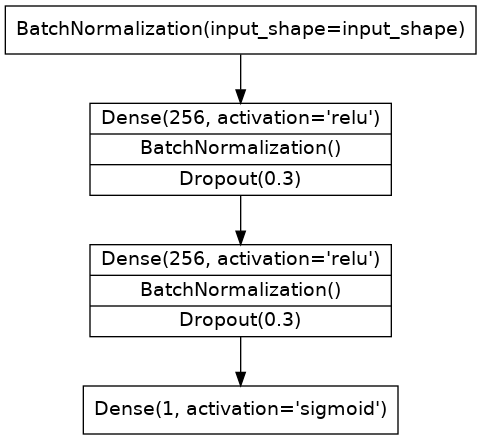

In [6]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorrt

model = keras.Sequential([
    layers.BatchNormalization(input_shape = input_shape),
    layers.Dense(256, activation = 'relu'),
    layers.Dropout(rate = 0.3),
    layers.BatchNormalization(),
    layers.Dense(256, activation = 'relu'),
    layers.Dropout(rate = 0.3),
    layers.BatchNormalization(),
    layers.Dense(1, activation = 'sigmoid'),

])

## 2) Add Optimizer, Loss, and Metric
Now compile the model with the Adam optimizer and binary versions of the cross-entropy loss and accuracy metric.

In [7]:
model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ["binary_accuracy"]
)

Finally, run this cell to train the model and view the learning curves. It may run for around 60 to 70 epochs, which could take a minute or two.

Epoch 1/200
175/175 [==============================] - 3s 11ms/step - loss: 0.4756 - binary_accuracy: 0.7722 - val_loss: 0.4257 - val_binary_accuracy: 0.8058
Epoch 2/200
175/175 [==============================] - 2s 12ms/step - loss: 0.4233 - binary_accuracy: 0.8010 - val_loss: 0.4023 - val_binary_accuracy: 0.8139
Epoch 3/200
175/175 [==============================] - 2s 12ms/step - loss: 0.4116 - binary_accuracy: 0.8060 - val_loss: 0.3950 - val_binary_accuracy: 0.8191
Epoch 4/200
175/175 [==============================] - 2s 10ms/step - loss: 0.4044 - binary_accuracy: 0.8095 - val_loss: 0.3892 - val_binary_accuracy: 0.8210
Epoch 5/200
175/175 [==============================] - 2s 10ms/step - loss: 0.3976 - binary_accuracy: 0.8140 - val_loss: 0.3854 - val_binary_accuracy: 0.8241
Epoch 6/200
175/175 [==============================] - 2s 9ms/step - loss: 0.3936 - binary_accuracy: 0.8165 - val_loss: 0.3824 - val_binary_accuracy: 0.8252
Epoch 7/200
175/175 [==============================] 

<Axes: title={'center': 'Accuracy'}>

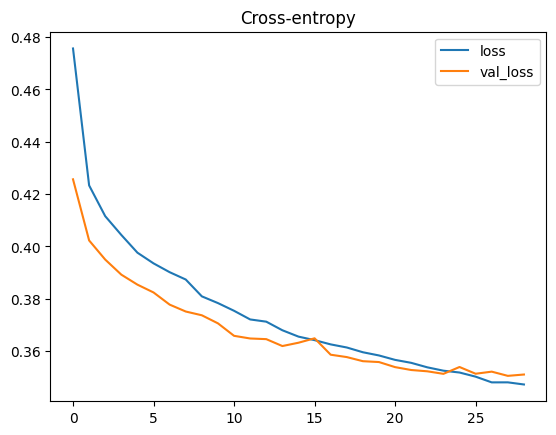

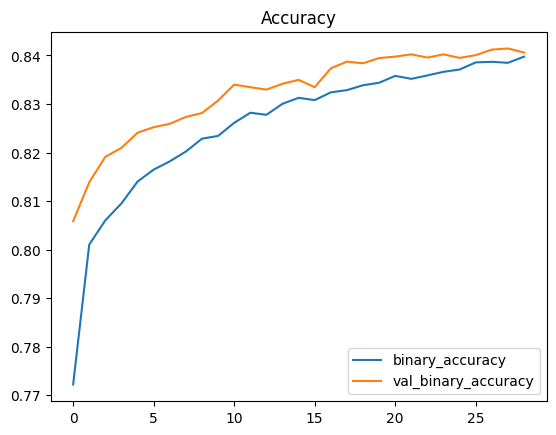

In [8]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=200,
    callbacks=[early_stopping],
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")